# 1. Histogramas 

In [82]:
import pandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import ticker 
import random
import math

COLORS = dict(
    [(1, '#b5770d'), (2, '#c6f927'), (4, '#feba35'), (3, '#e28bd8'), 
     (6, 'black'), (5, '#6b6e93'), (7, '#489be4'), (8, '#e929b8'), 
     (10, '#8e9d1b'), (9, '#b057bb'), (11, '#abe347'), (13, '#b64600'), (12, '#a1cb85')]
)

def get_color(key):
    if key in COLORS.keys():
        return COLORS[key]
    r = lambda: random.randint(0, 255)
    while True:
        color = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
        if not (color in COLORS.values()):
            COLORS[key] = color
            return color


def autolabel(bars, ax):
    for bar in bars:
        for rect in bar.patches:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


def count_anomalies_by_lenght(file):
    serie = pandas.read_csv(file)
    anomaly = 1
    anomaly_lenght = 0
    count = dict()
    counting = False
    for _ , row in serie.iterrows(): 
        if row['label'] == anomaly:
            counting = True
            anomaly_lenght += 1
        else:
            if counting:
                count[anomaly_lenght] = count.get(anomaly_lenght, 0) + 1
                counting = False
                anomaly_lenght = 0
    return count


def add_bars(data, ax):
    width = 1.05
    bars = []
    sorted_lengths = sorted(data.keys())
    positions = [width * j for j in range(len(sorted_lengths))]
    index = 0
    for length in sorted_lengths:
        bars.append(ax.bar(
            x=positions[index],
            height=data[length], 
            color=get_color(data[length]), 
            width=width/2, 
            edgecolor='white'
        ))
        index += 1
    ax.set_xticks(positions)
    ax.set_xticklabels(sorted_lengths)
    ax.set_ylim([0, max(data.values()) + 1])
    return bars

    
def plot_anomalies_description(title, series, chart_height=7):
    fig  = plt.figure(constrained_layout=True, figsize=(15, chart_height))
    grid = fig.add_gridspec(len(series) - 1, 2)
    fig.suptitle(title, fontsize=16)
    axis = []
    axis.append(fig.add_subplot(grid[0, 0]))
    axis.append(fig.add_subplot(grid[0, 1]))
    for i in range(1, len(series) - 1):
        axis.append(fig.add_subplot(grid[i, :]))
    for serie, ax in zip(series, axis):
        file, subtitle = serie
        ax.set_title(subtitle, fontsize=14)    
        ax.set_ylabel('Cantidad', fontsize=12)
        ax.set_xlabel('Longitud del Segmento', fontsize=12)
        data = count_anomalies_by_lenght(file)
        bars = add_bars(data, ax)
        autolabel(bars, ax)
    plt.show()


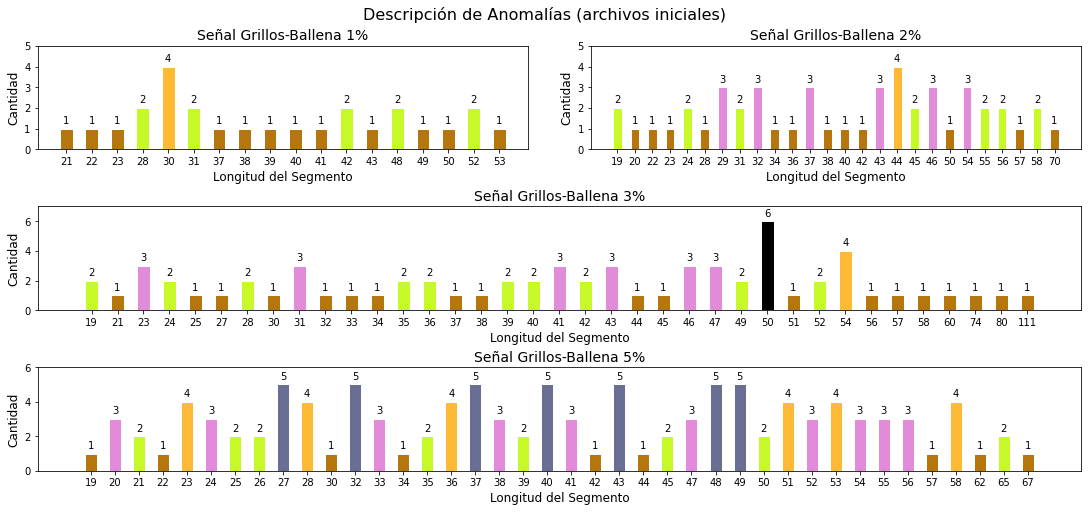

In [83]:
plot_anomalies_description(
    title='Descripción de Anomalías (archivos iniciales)',
    series=[
        ('señal_grillos_y_ballena_1porciento.csv', 'Señal Grillos-Ballena 1%'),
        ('señal_grillos_y_ballena_2porciento.csv', 'Señal Grillos-Ballena 2%'),
        ('señal_grillos_y_ballena_3porciento.csv', 'Señal Grillos-Ballena 3%'),
        ('señal_grillos_y_ballena_5porciento.csv', 'Señal Grillos-Ballena 5%')
    ]
)

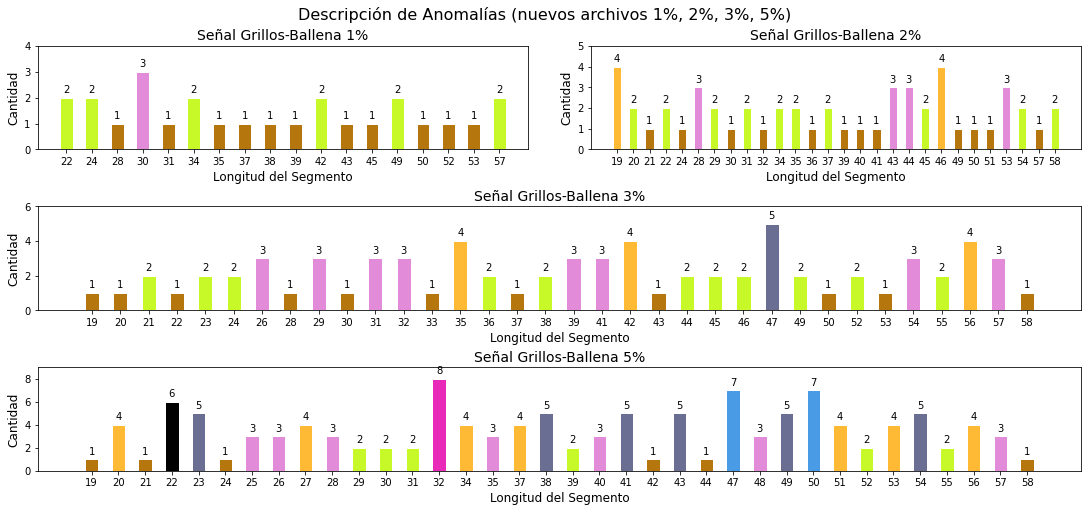

In [84]:

plot_anomalies_description(
    title='Descripción de Anomalías (nuevos archivos 1%, 2%, 3%, 5%)',
    series=[
        ('grillos_y_ballena_v2_1porciento.csv', 'Señal Grillos-Ballena 1%'),
        ('grillos_y_ballena_v2_2porciento.csv', 'Señal Grillos-Ballena 2%'),
        ('grillos_y_ballena_v2_3porciento.csv', 'Señal Grillos-Ballena 3%'),
        ('grillos_y_ballena_v2_5porciento.csv', 'Señal Grillos-Ballena 5%')
    ]
)



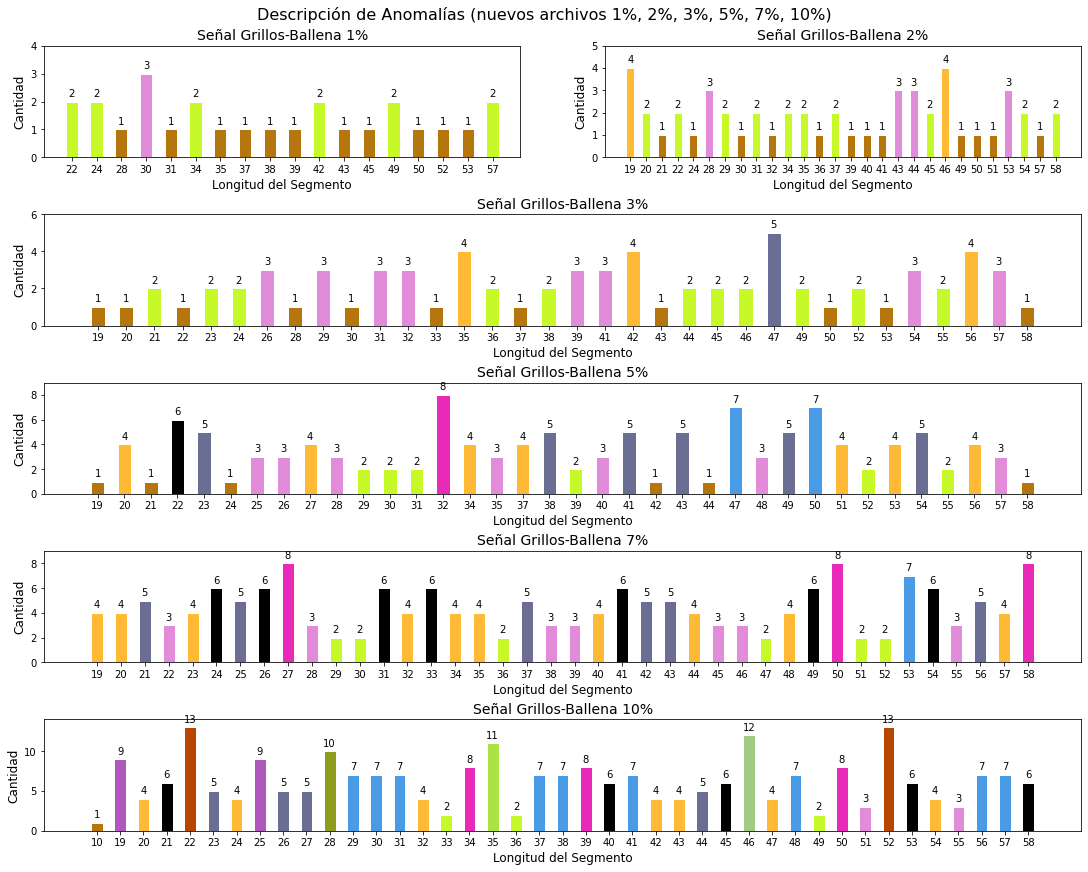

In [88]:

plot_anomalies_description(
    title='Descripción de Anomalías (nuevos archivos 1%, 2%, 3%, 5%, 7%, 10%)',
    series=[
        ('grillos_y_ballena_v2_1porciento.csv', 'Señal Grillos-Ballena 1%'),
        ('grillos_y_ballena_v2_2porciento.csv', 'Señal Grillos-Ballena 2%'),
        ('grillos_y_ballena_v2_3porciento.csv', 'Señal Grillos-Ballena 3%'),
        ('grillos_y_ballena_v2_5porciento.csv', 'Señal Grillos-Ballena 5%'),
        ('grillos_y_ballena_v2_7porciento.csv', 'Señal Grillos-Ballena 7%'),
        ('grillos_y_ballena_v2_10porciento.csv', 'Señal Grillos-Ballena 10%')
    ],
    chart_height=12
)


# 2. Tabla de percentiles

In [1]:
import numpy
import pandas
from typing import List


def write_two_variable_table_to_csv_file(data, file: str, columns: List[str], rows: List[str]):
    pandas.DataFrame(
        data,
        index=[row for row in rows],
        columns=[column for column in columns]
    ).to_csv(
        file,
        index=True,
        sep=';',
        decimal=',',
        encoding='utf-8-sig'
    )


def create_csv_with_percentiles(out_file: str, series: List[str], percentiles: List[int] = [10, 25, 50, 60, 75, 90]):
    def count_group_anomalies_by_length(file):
        data = pandas.read_csv(file)
        anomaly = 1
        anomaly_length = 0
        count = list()
        counting = False
        for _, row in data.iterrows():
            if row['label'] == anomaly:
                counting = True
                anomaly_length += 1
            else:
                if counting:
                    count.append(anomaly_length)
                    counting = False
                    anomaly_length = 0
        return sorted(count)

    def get_percentiles(group_count: List[int]):
        return [numpy.percentile(group_count, p) for p in percentiles]

    table_data = list()
    for serie, __ in series:
        table_data.append(get_percentiles(count_group_anomalies_by_length(serie)))

    write_two_variable_table_to_csv_file(
        table_data, 
        out_file, 
        ['P.{}%'.format(p) for p in percentiles], 
        [label for __, label in series]
    )
    


create_csv_with_percentiles(
    out_file='tabla_percentiles_series_naturales.csv',
    series=[
        ('grillos_y_ballena_v2_1porciento.csv', 'Grillos-Ballena 1%'),
        ('grillos_y_ballena_v2_2porciento.csv', 'Grillos-Ballena 2%'),
        ('grillos_y_ballena_v2_3porciento.csv', 'Grillos-Ballena 3%'),
        ('grillos_y_ballena_v2_5porciento.csv', 'Grillos-Ballena 5%'),
        ('grillos_y_ballena_v2_7porciento.csv', 'Grillos-Ballena 7%'),
        ('grillos_y_ballena_v2_10porciento.csv', 'Grillos-Ballena 10%')
    ],
)